In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class HMM(nn.Module):
    def __init__(self, num_states, num_observations):
        super(HMM, self).__init__()
        self.num_states = num_states
        self.num_observations = num_observations
        
        # Transition matrix A (state to state)
        self.A = nn.Parameter(torch.randn(num_states, num_states))
        
        # Emission matrix B (state to observation)
        self.B = nn.Parameter(torch.randn(num_states, num_observations))
        
        # Initial state distribution π
        self.pi = nn.Parameter(torch.randn(num_states))

    def forward(self, observations):
        seq_len = len(observations)
        log_alpha = torch.zeros(seq_len, self.num_states)
        
        # Initial state probabilities
        log_alpha[0] = torch.log_softmax(self.pi, dim=0) + torch.log_softmax(self.B, dim=1)[:, observations[0]]
        
        # Forward pass
        for t in range(1, seq_len):
            for j in range(self.num_states):
                log_alpha[t, j] = torch.logsumexp(log_alpha[t-1] + torch.log_softmax(self.A, dim=1)[:, j], dim=0) + torch.log_softmax(self.B, dim=1)[j,observations[t]]
        
        return log_alpha
    
    def predict(self, observations):
        seq_len = len(observations)
        log_delta = torch.zeros(seq_len, self.num_states)
        psi = torch.zeros(seq_len, self.num_states, dtype=torch.long)
        
        # Initial state probabilities
        log_delta[0] = torch.log_softmax(self.pi, dim=0) + torch.log_softmax(self.B[:, observations[0]], dim=0)
        
        # Viterbi pass
        for t in range(1, seq_len):
            for j in range(self.num_states):
                max_val, max_idx = torch.max(log_delta[t-1] + torch.log_softmax(self.A[:, j], dim=0), dim=0)
                log_delta[t, j] = max_val + torch.log_softmax(self.B[j, observations[t]], dim=0)
                psi[t, j] = max_idx
        
        # Backtrack
        states = torch.zeros(seq_len, dtype=torch.long)
        states[-1] = torch.argmax(log_delta[-1])
        for t in range(seq_len-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        
        return states

# Generate some synthetic data for demonstration
def generate_data(num_sequences, sequence_length, num_states, num_observations):
    A = np.random.rand(num_states, num_states)
    A = A / A.sum(axis=1, keepdims=True)
    B = np.random.rand(num_states, num_observations)
    B = B / B.sum(axis=1, keepdims=True)
    pi = np.random.rand(num_states)
    pi = pi / pi.sum()
    print(A,B,pi)
    
    sequences = []
    states = []
    
    for _ in range(num_sequences):
        seq = []
        state_seq = []
        state = np.random.choice(num_states, p=pi)
        for _ in range(sequence_length):
            obs = np.random.choice(num_observations, p=B[state])
            seq.append(obs)
            state_seq.append(state)
            state = np.random.choice(num_states, p=A[state])
        sequences.append(seq)
        states.append(state_seq)
    
    return sequences, states

# Parameters
num_states = 3
num_observations = 5
num_sequences = 100
sequence_length = 10

# Generate synthetic data
sequences, _ = generate_data(num_sequences, sequence_length, num_states, num_observations)

# Convert sequences to tensor
sequences = torch.tensor(sequences, dtype=torch.long)

# Initialize HMM model
model = HMM(num_states, num_observations)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for sequence in sequences:
        optimizer.zero_grad()
        log_alpha = model(sequence)
        loss = -torch.logsumexp(log_alpha[-1], dim=0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/num_sequences}')

# Test the model with a new sequence
test_sequence = torch.tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4], dtype=torch.long)
predicted_states = model.predict(test_sequence)
print("Predicted States:", predicted_states)


[[0.54731403 0.42694336 0.02574261]
 [0.37323558 0.19499239 0.43177204]
 [0.19273426 0.72463143 0.08263431]] [[2.97666407e-01 3.25956779e-01 4.84393065e-04 1.67585752e-01
  2.08306669e-01]
 [2.01534179e-01 2.11022232e-01 1.78684464e-01 2.46482666e-01
  1.62276460e-01]
 [1.13399826e-01 1.39256350e-01 9.07464921e-02 5.79611972e-01
  7.69853597e-02]] [0.2066849  0.56281579 0.23049931]
Epoch 1/100, Loss: 16.23250284194946
Epoch 2/100, Loss: 15.583347864151001
Epoch 3/100, Loss: 15.521059198379517
Epoch 4/100, Loss: 15.505535898208619
Epoch 5/100, Loss: 15.497172794342042
Epoch 6/100, Loss: 15.491176767349243
Epoch 7/100, Loss: 15.48656265258789
Epoch 8/100, Loss: 15.482920751571655
Epoch 9/100, Loss: 15.479993705749513
Epoch 10/100, Loss: 15.477599716186523
Epoch 11/100, Loss: 15.475605773925782
Epoch 12/100, Loss: 15.473912267684936
Epoch 13/100, Loss: 15.472446269989014
Epoch 14/100, Loss: 15.47115361213684
Epoch 15/100, Loss: 15.469995155334473
Epoch 16/100, Loss: 15.468944082260132
Epo

In [4]:
torch.softmax(model.A, dim=1),torch.softmax(model.B, dim=1),torch.softmax(model.pi, dim=0)

(tensor([[7.9661e-01, 1.0257e-01, 1.0082e-01],
         [4.8738e-01, 1.7493e-01, 3.3769e-01],
         [9.7432e-03, 9.9023e-01, 2.4559e-05]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2921, 0.2832, 0.0907, 0.1546, 0.1793],
         [0.0515, 0.2198, 0.0236, 0.5912, 0.1139],
         [0.3339, 0.1655, 0.2219, 0.0737, 0.2050]], grad_fn=<SoftmaxBackward0>),
 tensor([0.2439, 0.3536, 0.4025], grad_fn=<SoftmaxBackward0>))

In [ ]:
[[0.12291936 0.74335405 0.13372659]
 [0.63201973 0.28516531 0.08281496]
 [0.46170561 0.49458163 0.04371276]]
[[0.21929858 0.13288209 0.27078613 0.31413857 0.06289463]
 [0.18128776 0.05557091 0.31089548 0.24282768 0.20941817]
 [0.0211762  0.28873829 0.27137095 0.24494855 0.17376601]]

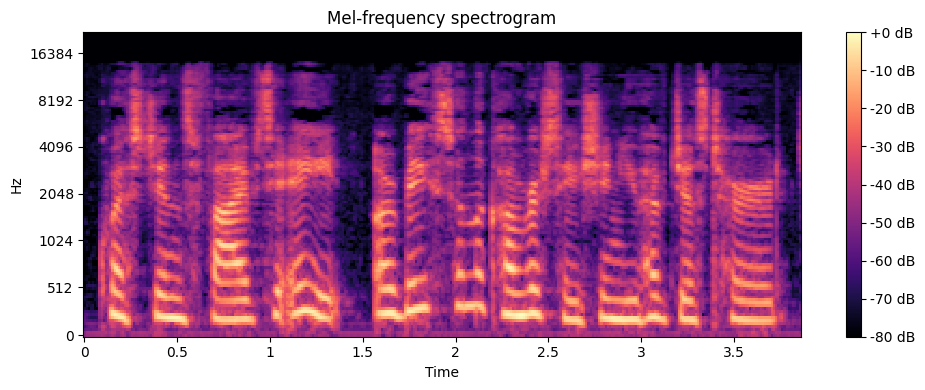

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 加载音频文件
audio_path = '../tts/examples/default.wav'
y, sr = librosa.load(audio_path, sr=None)

# 计算梅尔谱
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# 转换为对数刻度
S_dB = librosa.power_to_db(S, ref=np.max)

# 显示梅尔谱图
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()